## NLP solver reference
- sciPy
    - https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html#constrained-minimization-of-multivariate-scalar-functions-minimize
    - https://docs.scipy.org/doc/scipy/reference/optimize.html

In [1]:
##### add python path #####
import sys
import os
PATH = os.getcwd()
for dir_idx, dir_name in enumerate(PATH.split('/')):
    if 'optimal_control' in dir_name.lower():
        PATH = '/'.join(PATH.split('/')[:(dir_idx+1)])
        break
if not PATH in sys.path:
    sys.path.append(PATH)
###########################
import env

from scipy.optimize import minimize
from scipy.optimize import Bounds

import matplotlib.pyplot as plt
import numpy as np
import time

state 및 control을 N개의 piece-wise로 쪼갠다고 가정.
$$
x[0:N+1] : u_0, u_1, ..., u_N \\
x[N+1:5*N+5] : x_0, \dot{x}_0, \theta_0, \dot{\theta}_0, x_1, \dot{x}_1, ..., x_N, \dot{x}_N, \theta_N, \dot{\theta}_N \\
$$

```
x, x_dot, theta, theta_dot = state
```

In [42]:
# declare environmental variables
u_dim = 1
x_dim = 4
dt = 0.1

R_mat = np.eye(u_dim)*0.1
Q_mat = np.eye(x_dim)
Qf_mat = np.eye(x_dim)*100.0

In [43]:
gravity = 9.8
masscart = 1.0
masspole = 0.1
total_mass = masspole + masscart
length = 0.5
polemass_length = masspole*length

def dynamics(state, action):
    x = state[:, 0]
    x_dot = state[:, 1]
    theta = state[:, 2]
    theta_dot = state[:, 3]
    force = action[:, 0]

    costheta = np.cos(theta)
    sintheta = np.sin(theta)
    temp = (force + polemass_length * theta_dot * theta_dot * sintheta) / total_mass
    theta_acc = (gravity * sintheta - costheta* temp) / (length * (4.0/3.0 - masspole * costheta * costheta / total_mass))
    x_acc  = temp - polemass_length * theta_acc * costheta / total_mass
    
    state_dot = np.array([x_dot, x_acc, theta_dot, theta_acc]).T
    return state_dot

In [44]:
def obj_func(x):
    N = int(len(x)/5 - 1)    
    u_list = np.array(x[:N+1]).reshape((N+1, u_dim))
    x_list = np.array(x[N+1:]).reshape((N+1, x_dim))
        
    f = 0.5*np.matmul(x_list[N, :], np.matmul(Qf_mat, x_list[N, :]))
    f += 0.5*dt*np.sum(np.matmul(u_list[:N, :], R_mat)*u_list[:N, :])
    f += 0.5*dt*np.sum(np.matmul(x_list[:N, :], Q_mat)*x_list[:N, :])
    f = f.ravel()[0]
    return f

def obj_jacobian(x):
    N = int(len(x)/5 - 1)
    u_list = np.array(x[:N+1]).reshape((N+1, u_dim))
    x_list = np.array(x[N+1:]).reshape((N+1, x_dim))
    jacobian = np.zeros(len(x))
    for i in range(N):
        jacobian[i*u_dim : (i + 1)*u_dim] = dt*np.matmul(R_mat, u_list[i]).ravel()
        jacobian[(N + 1)*u_dim + i*x_dim : (N + 1)*u_dim + (i+1)*x_dim] = dt*np.matmul(Q_mat, x_list[i]).ravel()
    jacobian[(x_dim + u_dim)*(N + 1) - x_dim : (x_dim + u_dim)*(N + 1)] = np.matmul(Qf_mat, x_list[N]).ravel()
    return jacobian

In [45]:
def eq_cons_func(x):
    N = int(len(x)/5 - 1)
    u_list = np.array(x[:N+1]).reshape((N+1, u_dim))
    x_list = np.array(x[N+1:]).reshape((N+1, x_dim))
    
    # get x_dot from dynamics
    x_dot_list = dynamics(x_list, u_list)
    
    # transform variables for pice-wise polynomial
    x_left = x_list[:N,:]
    x_right = x_list[1:,:]
    x_dot_left = x_dot_list[:N,:]
    x_dot_right = x_dot_list[1:,:]
    u_left = u_list[:N,:]
    u_right = u_list[1:,:]
    
    # get collocation points
    x_c = 0.5*(x_left + x_right) + dt*0.125*(x_dot_left - x_dot_right)
    u_c = 0.5*(u_left + u_right)
    x_dot_c = dynamics(x_c, u_c)

    # equality constraint
    e_cons = np.ravel(x_left - x_right + dt*(x_dot_left + 4*x_dot_c + x_dot_right)/6)
    return e_cons

eq_cons = {
    'type':'eq',
    'fun' :eq_cons_func,
    }

In [46]:
N = 10
init_state = [0.1, 0.0, 0.0, 0.0]

init_action_list = np.zeros((N+1,u_dim))
init_state_list = np.zeros((N+1,x_dim))
init_state_list[:x_dim] = init_state
x_init = np.concatenate([init_action_list.ravel(), init_state_list.ravel()])

lowers = np.array([-np.inf]*((N+1)*u_dim) + init_state + [-np.inf]*(N*x_dim))
uppers = np.array([np.inf]*((N+1)*u_dim) + init_state + [np.inf]*(N*x_dim))
bounds = Bounds(lowers, uppers)

In [49]:
start_t = time.time()
res = minimize(obj_func, x_init, method="SLSQP", jac=obj_jacobian, bounds=bounds, constraints=[eq_cons], \
               options={'ftol':1e-5, 'disp':True, 'maxiter':10, 'eps':1e-10})
print("elapsed time : {:.5f} s".format(time.time() - start_t))

Iteration limit exceeded    (Exit mode 9)
            Current function value: 0.14136938369312918
            Iterations: 11
            Function evaluations: 15
            Gradient evaluations: 11
elapsed time : 0.06377 s


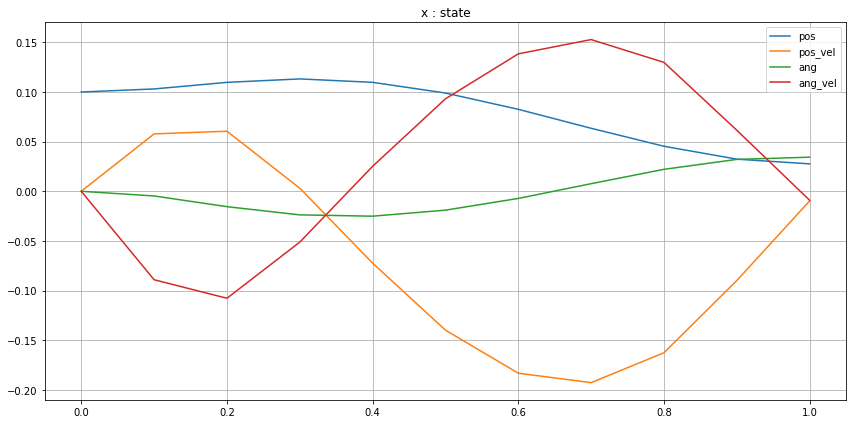

In [50]:
N = int(len(res.x)/5 - 1)
t_list = np.linspace(0, dt*N, N+1)
u_list = np.array(res.x[:N+1]).reshape((N+1, u_dim))
x_list = np.array(res.x[N+1:]).reshape((N+1, x_dim))

fig_size = 6
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(fig_size*2, fig_size))
ax.plot(t_list, x_list[:,0], label="pos")
ax.plot(t_list, x_list[:,1], label="pos_vel")
ax.plot(t_list, x_list[:,2], label="ang")
ax.plot(t_list, x_list[:,3], label="ang_vel")

ax.grid()
ax.legend()
ax.set_title('x : state')

fig.tight_layout()
plt.show()